In [1]:
!pip install efficientnet_pytorch

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
import os
import numpy as np
np.random.seed(0)
import torch
torch.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
import datetime
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch.utils.data.sampler import SubsetRandomSampler
from mlxtend.evaluate import confusion_matrix
import matplotlib.pyplot as plt
import pandas as pd
from mlxtend.plotting import plot_confusion_matrix
from collections import OrderedDict 
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
import optuna

DIR = os.getcwd()
n_epochs = 30
EPOCHS = 30

debug=True
train_the_model=True
test_the_network=True
display_on_console=False
confusion_matrix_on=True
find_std_and_mean=False


DEVICE = torch.device("cuda")

# define dataloader parameters

batch_size = 40
num_workers=8
name_of_csv="Results_of_Stage_II_Optimized_ML_Model"
path_to_save='Stage_II_Optimzied_Model.pth'
check_with_non_skew=False

if check_with_non_skew==True:
    batch_size = 10

In [2]:
# define training and test data directories
data_dir=os.path.join(DIR,'stage_2_sorted_images_four_classes')

train_dir = os.path.join(data_dir, 'train/')
test_dir = os.path.join(data_dir, 'test/')

# classes are folders in each directory with these names
classes = sorted(os.listdir(train_dir))
print(classes)
N_classes = len(classes)


['Other', 'back ear tearing', 'front ear tearing', 'tape tearing']


In [3]:
# percentage of training set to use as validation
valid_size = 0.2

# VGG-16 Takes 224x224 images as input, so we resize all of them
train_transforms = transforms.Compose([transforms.RandomRotation(40),
                                           transforms.RandomResizedCrop(224),
                                           transforms.RandomHorizontalFlip(),
                                           transforms.ToTensor(),
                                           transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.Resize(255),
                                          transforms.CenterCrop(224),
                                          transforms.ToTensor(),
                                          transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])


train_data = datasets.ImageFolder(train_dir, transform=train_transforms)
test_data = datasets.ImageFolder(test_dir, transform=test_transforms)


percentage_train_data= round((len(train_data)*100/len(train_data+test_data)))
percentage_test_data=round((len(test_data)*100/len(train_data+test_data)))

# print out some data stats
print('Num training images: {} among {} batches.|| {}% out of Total Images'.format(len(train_data),len(train_data)/batch_size,percentage_train_data) )
print('Num test images: {} among {} batches. || {}% out of Total Images'.format(len(test_data),len(test_data)/batch_size,percentage_test_data) )

Num training images: 5821 among 145.525 batches.|| 85% out of Total Images
Num test images: 1028 among 25.7 batches. || 15% out of Total Images


In [4]:
#################################
#Prepare Dataloaders for Batches#
#################################

# obtain training indices that will be used for validation
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)


# prepare data loaders

test_loader = torch.utils.data.DataLoader(test_data, batch_size=20, 
                                          num_workers=num_workers, shuffle=True)


In [5]:
def get_data():
    # Load datase
    
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
                     sampler=train_sampler,num_workers=num_workers, shuffle=False)
    valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
                    sampler=valid_sampler, num_workers=num_workers, shuffle=False)
    
    return train_loader, valid_loader

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

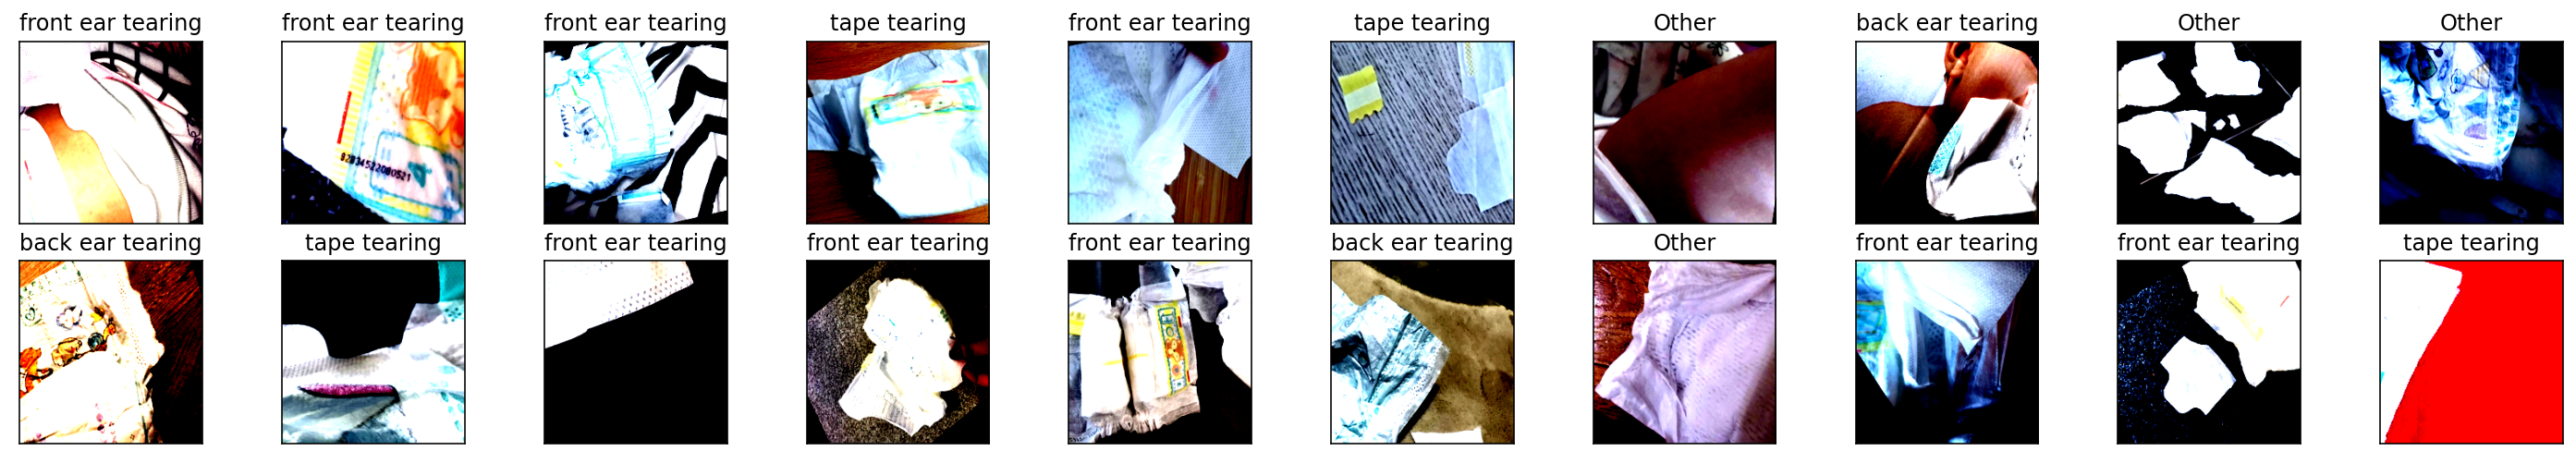

In [6]:
# Visualize some sample data
if check_with_non_skew==False:
    # obtain one batch of training images
    dataiter = iter(get_data()[0])
    images, labels = dataiter.next()
    images = images.numpy() # convert images to numpy for display
    images.shape

    # plot the images in the batch, along with the corresponding labels
    fig = plt.figure(figsize=(25, 4))
    for idx in np.arange(20):
        ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
        plt.imshow(np.transpose(images[idx], (1, 2, 0)))
        ax.set_title(classes[labels[idx]])

In [7]:
num_GPUs = torch.cuda.device_count()

In [8]:
def define_model(trial):
    
    # We optimize the base_model, number of layers in Fully Connected classifier, hidden untis and 
    # dropout ratio in each layer.
    
    base_model = trial.suggest_categorical("base_model", ["VGG", "RESNET", "EfficientNet"])

    if base_model == "VGG":
        model = models.vgg19_bn(pretrained=True)
        in_features = 16000
        n_layers = trial.suggest_int("n_layers_v", 1, 3)
        layers = []
        if n_layers > 0:
            out_features = trial.suggest_int("n_units_l1_v", int(in_features/2), in_features)
            layers.append(nn.Linear(25088, out_features))
            layers.append(nn.ReLU())
            #p1 = trial.suggest_uniform("dropout_l1_v", 0.2, 0.6)
            p1 = 0.5
            layers.append(nn.Dropout(p1))
            in_features = out_features
            if n_layers > 1:
                out_features = trial.suggest_int("n_units_l2_v", int(in_features/2), in_features)
                layers.append(nn.Linear(in_features, out_features))
                layers.append(nn.ReLU())
                #p2 = trial.suggest_uniform("dropout_l2_v", 0.2, 0.6)
                p2 = 0.5
                layers.append(nn.Dropout(p2))
                in_features = out_features
                if n_layers > 2:
                    out_features = trial.suggest_int("n_units_l3_v", int(in_features/2), in_features)
                    layers.append(nn.Linear(in_features, out_features))
                    layers.append(nn.ReLU())
                    #p3 = trial.suggest_uniform("dropout_l3_v", 0.2, 0.6)
                    p3 = 0.6
                    layers.append(nn.Dropout(p3))
                    in_features = out_features
        layers.append(nn.Linear(in_features, N_classes))
        model.classifier = nn.Sequential(*layers)
        print('VGG is running.....')
        
    elif base_model == "RESNET":
        model = model = models.wide_resnet101_2(pretrained=True)
        in_features = model.fc.in_features
        n_layers = trial.suggest_int("n_layers_r", 1, 3)
        layers = []
        if n_layers > 0:
            out_features = trial.suggest_int("n_units_l1_r", int(in_features/2), in_features)
            layers.append(nn.Linear(in_features, out_features))
            layers.append(nn.ReLU())
            #p1 = trial.suggest_uniform("dropout_l1_r", 0.2, 0.6)
            p1 = 0.5
            layers.append(nn.Dropout(p1))
            in_features = out_features
            if n_layers > 1:
                out_features = trial.suggest_int("n_units_l2_r", int(in_features/2), in_features)
                layers.append(nn.Linear(in_features, out_features))
                layers.append(nn.ReLU())
                #p2 = trial.suggest_uniform("dropout_l2_r", 0.2, 0.6)
                p2 = 0.5
                layers.append(nn.Dropout(p2))
                in_features = out_features
                if n_layers > 2:
                    out_features = trial.suggest_int("n_units_l3_r", int(in_features/2), in_features)
                    layers.append(nn.Linear(in_features, out_features))
                    layers.append(nn.ReLU())
                    #p3 = trial.suggest_uniform("dropout_l3_r", 0.2, 0.6)
                    p3 = 0.6
                    layers.append(nn.Dropout(p3))
                    in_features = out_features
        layers.append(nn.Linear(in_features, N_classes))
        model.fc = nn.Sequential(*layers)
        print('RESNET is running.....')
        
    elif base_model == "EfficientNet":
        from efficientnet_pytorch import EfficientNet
        
        base_model_efficientnet = trial.suggest_categorical("base_model_efficientnet", ["b0", "b1", "b2"])
        
        if base_model_efficientnet == "b0":
            model = EfficientNet.from_pretrained('efficientnet-b0', num_classes=N_classes)
        elif base_model_efficientnet == "b1":
            model = EfficientNet.from_pretrained('efficientnet-b1', num_classes=N_classes)
        elif base_model_efficientnet == "b2":
            model = EfficientNet.from_pretrained('efficientnet-b2', num_classes=N_classes)
        
        in_features = model._fc.in_features

        n_layers = trial.suggest_int("n_layers_e", 1, 3)
        layers = []

        if n_layers > 0:
            out_features = trial.suggest_int("n_units_l1_e", int(in_features/2), in_features)
            layers.append(nn.Linear(in_features, out_features))
            layers.append(nn.ReLU())
            #p1 = trial.suggest_uniform("dropout_l1_e", 0.2, 0.6)
            p1 = 0.5
            layers.append(nn.Dropout(p1))
            in_features = out_features
            if n_layers > 1:
                out_features = trial.suggest_int("n_units_l2_e", int(in_features/2), in_features)
                layers.append(nn.Linear(in_features, out_features))
                layers.append(nn.ReLU())
                #p2 = trial.suggest_uniform("dropout_l2_e", 0.2, 0.6)
                p2 = 0.5
                layers.append(nn.Dropout(p2))
                in_features = out_features
                if n_layers > 2:
                    out_features = trial.suggest_int("n_units_l3_e", int(in_features/2), in_features)
                    layers.append(nn.Linear(in_features, out_features))
                    layers.append(nn.ReLU())
                    #p3 = trial.suggest_uniform("dropout_l3:e", 0.2, 0.6)
                    p3 = 0.6
                    layers.append(nn.Dropout(p3))
                    in_features = out_features
        layers.append(nn.Linear(in_features, N_classes))
        model._fc = nn.Sequential(*layers)
        print('EfficientNet is running.....')

    return model

In [9]:
def objective(trial):
    
    DEVICE = torch.device("cuda")
    # Generate the model
    model = define_model(trial)
    model = torch.nn.DataParallel(model, device_ids=list(range(num_GPUs)))
    model.to(DEVICE)

    # Generate the optimizers.
    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "SGD"])
    lr = trial.suggest_loguniform("lr", 0.0001, 0.01)
    optimizer = getattr(optim, optimizer_name)(model.parameters(), lr=lr)

    # specify loss function (categorical cross-entropy)
    criterion = nn.CrossEntropyLoss()
    
    # Get the dataset.
    train_loader, valid_loader = get_data()
    valid_loss_min = np.Inf # track change in validation loss
    training_loss_array=[]
    valid_loss_array=[]
    
    # Training of the model.
    model.train()
    for epoch in range(EPOCHS):
        torch.cuda.empty_cache()

        # keep track of training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        for data, target in train_loader:
    
            data, target = data.to(DEVICE), target.to(DEVICE)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            
        print('Training done... Validating....')

        # Validation of the model.
        model.eval()
        correct = 0
        with torch.no_grad():
            for data, target in valid_loader:
                
                data, target = data.to(DEVICE), target.to(DEVICE)
                output = model(data)
                # Get the index of the max log-probability.
                loss = criterion(output, target)
                # update average validation loss 
                valid_loss += loss.item()
                pred = output.argmax(dim=1, keepdim=True)
                correct += pred.eq(target.view_as(pred)).sum().item()

        N_Valid_Examples = int(0.2*(len(train_loader.dataset)))
        accuracy = correct / (N_Valid_Examples*1.00)
        
        print('Accuracy for validation dataset is: ', accuracy)
        
        train_loss = train_loss/len(train_loader.dataset)
        valid_loss = valid_loss/(0.2*len(valid_loader.dataset))

        # print training/validation statistics 
        print('Epoch: {}/{} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, EPOCHS, train_loss, valid_loss))
        
        trial.report(accuracy, epoch)

        # Handle pruning based on the intermediate value.
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    return accuracy

In [12]:
n = 20
sampler = optuna.samplers.TPESampler(seed=10)
study = optuna.create_study(study_name = 'Optimization', sampler = sampler, direction="maximize", 
                            storage='sqlite:///stage_II_optimization.db',
                            load_if_exists=True)

study.optimize(objective, n_trials=n)

pruned_trials = [t for t in study.trials if t.state == optuna.structs.TrialState.PRUNED]
complete_trials = [t for t in study.trials if t.state == optuna.structs.TrialState.COMPLETE]

print("Study statistics: ")
print("  Number of finished trials: ", len(study.trials))
print("  Number of pruned trials: ", len(pruned_trials))
print("  Number of complete trials: ", len(complete_trials))

print("Best trial:")
trial = study.best_trial

print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2020-08-05 08:47:42,882] Using an existing study with name 'Optimization' instead of creating a new one.


VGG is running.....


C:\Users\makerspace.im\Anaconda3\envs\pyTorch\lib\site-packages\torch\nn\parallel\data_parallel.py:26: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))
C:\Users\makerspace.im\Anaconda3\envs\pyTorch\lib\site-packages\torch\cuda\nccl.py:24: UserWarning: PyTorch is not compiled with NCCL support
  warnings.warn('PyTorch is not compiled with NCCL support')


Training done... Validating....
Accuracy for validation dataset is:  0.3651202749140893
Epoch: 0/30 	Training Loss: 0.027249 	Validation Loss: 0.034567
Training done... Validating....
Accuracy for validation dataset is:  0.3651202749140893
Epoch: 1/30 	Training Loss: 0.026803 	Validation Loss: 0.034176


[I 2020-08-05 08:55:05,651] Setting status of trial#60 as TrialState.PRUNED. 


RESNET is running.....
Training done... Validating....
Accuracy for validation dataset is:  0.3651202749140893
Epoch: 0/30 	Training Loss: 0.026872 	Validation Loss: 0.033799
Training done... Validating....
Accuracy for validation dataset is:  0.43900343642611683
Epoch: 1/30 	Training Loss: 0.025867 	Validation Loss: 0.031870
Training done... Validating....
Accuracy for validation dataset is:  0.5292096219931272
Epoch: 2/30 	Training Loss: 0.023531 	Validation Loss: 0.028275
Training done... Validating....
Accuracy for validation dataset is:  0.5481099656357389
Epoch: 3/30 	Training Loss: 0.020237 	Validation Loss: 0.027670
Training done... Validating....
Accuracy for validation dataset is:  0.6125429553264605
Epoch: 4/30 	Training Loss: 0.018705 	Validation Loss: 0.024581
Training done... Validating....
Accuracy for validation dataset is:  0.6262886597938144
Epoch: 5/30 	Training Loss: 0.017926 	Validation Loss: 0.023600
Training done... Validating....
Accuracy for validation dataset 

[I 2020-08-05 10:43:42,014] Finished trial#61 with value: 0.6838487972508591 with parameters: {'base_model': 'RESNET', 'n_layers_r': 2, 'n_units_l1_r': 2002, 'n_units_l2_r': 1993, 'optimizer': 'SGD', 'lr': 0.006090598533897966}. Best is trial#7 with value: 0.7164948453608248.


RESNET is running.....
Training done... Validating....
Accuracy for validation dataset is:  0.3651202749140893
Epoch: 0/30 	Training Loss: 0.026938 	Validation Loss: 0.033902
Training done... Validating....
Accuracy for validation dataset is:  0.4329896907216495
Epoch: 1/30 	Training Loss: 0.025835 	Validation Loss: 0.031810
Training done... Validating....
Accuracy for validation dataset is:  0.47852233676975947
Epoch: 2/30 	Training Loss: 0.024369 	Validation Loss: 0.030197


[I 2020-08-05 10:54:28,643] Setting status of trial#62 as TrialState.PRUNED. 


RESNET is running.....
Training done... Validating....
Accuracy for validation dataset is:  0.3651202749140893
Epoch: 0/30 	Training Loss: 0.026915 	Validation Loss: 0.033791
Training done... Validating....
Accuracy for validation dataset is:  0.41580756013745707
Epoch: 1/30 	Training Loss: 0.025374 	Validation Loss: 0.032465
Training done... Validating....
Accuracy for validation dataset is:  0.5549828178694158
Epoch: 2/30 	Training Loss: 0.023149 	Validation Loss: 0.027993
Training done... Validating....
Accuracy for validation dataset is:  0.5945017182130584
Epoch: 3/30 	Training Loss: 0.020004 	Validation Loss: 0.025153
Training done... Validating....
Accuracy for validation dataset is:  0.6142611683848798
Epoch: 4/30 	Training Loss: 0.018959 	Validation Loss: 0.025061
Training done... Validating....
Accuracy for validation dataset is:  0.5893470790378007
Epoch: 5/30 	Training Loss: 0.017690 	Validation Loss: 0.025040
Training done... Validating....
Accuracy for validation dataset 

[I 2020-08-05 11:23:21,849] Setting status of trial#63 as TrialState.PRUNED. 


RESNET is running.....
Training done... Validating....
Accuracy for validation dataset is:  0.2800687285223368
Epoch: 0/30 	Training Loss: 0.027632 	Validation Loss: 0.035303
Training done... Validating....
Accuracy for validation dataset is:  0.30584192439862545
Epoch: 1/30 	Training Loss: 0.027486 	Validation Loss: 0.035075


[I 2020-08-05 11:30:44,526] Setting status of trial#64 as TrialState.PRUNED. 


RESNET is running.....
Training done... Validating....
Accuracy for validation dataset is:  0.3651202749140893
Epoch: 0/30 	Training Loss: 0.026977 	Validation Loss: 0.034072
Training done... Validating....
Accuracy for validation dataset is:  0.44587628865979384
Epoch: 1/30 	Training Loss: 0.025841 	Validation Loss: 0.031638
Training done... Validating....
Accuracy for validation dataset is:  0.5403780068728522
Epoch: 2/30 	Training Loss: 0.024135 	Validation Loss: 0.029197
Training done... Validating....
Accuracy for validation dataset is:  0.5876288659793815
Epoch: 3/30 	Training Loss: 0.020659 	Validation Loss: 0.025769
Training done... Validating....
Accuracy for validation dataset is:  0.6056701030927835
Epoch: 4/30 	Training Loss: 0.018752 	Validation Loss: 0.025135
Training done... Validating....
Accuracy for validation dataset is:  0.5670103092783505
Epoch: 5/30 	Training Loss: 0.017932 	Validation Loss: 0.027651
Training done... Validating....
Accuracy for validation dataset 

[I 2020-08-05 13:19:04,770] Finished trial#65 with value: 0.3384879725085911 with parameters: {'base_model': 'RESNET', 'n_layers_r': 2, 'n_units_l1_r': 1769, 'n_units_l2_r': 1231, 'optimizer': 'SGD', 'lr': 0.005649894328618143}. Best is trial#7 with value: 0.7164948453608248.


RESNET is running.....
Training done... Validating....
Accuracy for validation dataset is:  0.3651202749140893
Epoch: 0/30 	Training Loss: 0.027367 	Validation Loss: 0.034618
Training done... Validating....
Accuracy for validation dataset is:  0.3651202749140893
Epoch: 1/30 	Training Loss: 0.026665 	Validation Loss: 0.033734


[I 2020-08-05 13:26:22,322] Setting status of trial#66 as TrialState.PRUNED. 


RESNET is running.....
Training done... Validating....
Accuracy for validation dataset is:  0.3651202749140893
Epoch: 0/30 	Training Loss: 0.027045 	Validation Loss: 0.034018
Training done... Validating....
Accuracy for validation dataset is:  0.4518900343642612
Epoch: 1/30 	Training Loss: 0.025946 	Validation Loss: 0.031716
Training done... Validating....
Accuracy for validation dataset is:  0.5077319587628866
Epoch: 2/30 	Training Loss: 0.023183 	Validation Loss: 0.028224
Training done... Validating....
Accuracy for validation dataset is:  0.5446735395189003
Epoch: 3/30 	Training Loss: 0.020027 	Validation Loss: 0.026952
Training done... Validating....
Accuracy for validation dataset is:  0.5773195876288659
Epoch: 4/30 	Training Loss: 0.018703 	Validation Loss: 0.025504
Training done... Validating....
Accuracy for validation dataset is:  0.5292096219931272
Epoch: 5/30 	Training Loss: 0.017764 	Validation Loss: 0.038718


[I 2020-08-05 13:48:04,346] Setting status of trial#67 as TrialState.PRUNED. 


RESNET is running.....
Training done... Validating....
Accuracy for validation dataset is:  0.3651202749140893
Epoch: 0/30 	Training Loss: 0.027363 	Validation Loss: 0.034702
Training done... Validating....
Accuracy for validation dataset is:  0.3651202749140893
Epoch: 1/30 	Training Loss: 0.026611 	Validation Loss: 0.033252


[I 2020-08-05 13:55:18,141] Setting status of trial#68 as TrialState.PRUNED. 


RESNET is running.....
Training done... Validating....
Accuracy for validation dataset is:  0.3651202749140893
Epoch: 0/30 	Training Loss: 0.027370 	Validation Loss: 0.034388
Training done... Validating....
Accuracy for validation dataset is:  0.3651202749140893
Epoch: 1/30 	Training Loss: 0.026564 	Validation Loss: 0.033553


[I 2020-08-05 14:02:37,619] Setting status of trial#69 as TrialState.PRUNED. 


Loaded pretrained weights for efficientnet-b2
EfficientNet is running.....
Training done... Validating....
Accuracy for validation dataset is:  0.33505154639175255
Epoch: 0/30 	Training Loss: 0.030540 	Validation Loss: 7.594059
Training done... Validating....
Accuracy for validation dataset is:  0.3651202749140893
Epoch: 1/30 	Training Loss: 36560488569375152.000000 	Validation Loss: 0.034413


[I 2020-08-05 14:09:46,058] Setting status of trial#70 as TrialState.PRUNED. 


RESNET is running.....
Training done... Validating....
Accuracy for validation dataset is:  0.3651202749140893
Epoch: 0/30 	Training Loss: 0.026931 	Validation Loss: 0.034047
Training done... Validating....
Accuracy for validation dataset is:  0.38402061855670105
Epoch: 1/30 	Training Loss: 0.025895 	Validation Loss: 0.032265
Training done... Validating....
Accuracy for validation dataset is:  0.5472508591065293
Epoch: 2/30 	Training Loss: 0.024121 	Validation Loss: 0.029309
Training done... Validating....
Accuracy for validation dataset is:  0.2972508591065292
Epoch: 3/30 	Training Loss: 0.020906 	Validation Loss: 0.036764
Training done... Validating....
Accuracy for validation dataset is:  0.6237113402061856
Epoch: 4/30 	Training Loss: 0.019507 	Validation Loss: 0.024139
Training done... Validating....
Accuracy for validation dataset is:  0.6030927835051546
Epoch: 5/30 	Training Loss: 0.018589 	Validation Loss: 0.023975
Training done... Validating....
Accuracy for validation dataset 

[I 2020-08-05 14:49:41,703] Setting status of trial#71 as TrialState.PRUNED. 


RESNET is running.....
Training done... Validating....
Accuracy for validation dataset is:  0.3651202749140893
Epoch: 0/30 	Training Loss: 0.027015 	Validation Loss: 0.033935
Training done... Validating....
Accuracy for validation dataset is:  0.36597938144329895
Epoch: 1/30 	Training Loss: 0.026264 	Validation Loss: 0.032446


[I 2020-08-05 14:56:54,334] Setting status of trial#72 as TrialState.PRUNED. 


RESNET is running.....
Training done... Validating....
Accuracy for validation dataset is:  0.3651202749140893
Epoch: 0/30 	Training Loss: 0.026952 	Validation Loss: 0.033961
Training done... Validating....
Accuracy for validation dataset is:  0.37800687285223367
Epoch: 1/30 	Training Loss: 0.025715 	Validation Loss: 0.033852
Training done... Validating....
Accuracy for validation dataset is:  0.32216494845360827
Epoch: 2/30 	Training Loss: 0.023717 	Validation Loss: 0.035741


[I 2020-08-05 15:07:42,093] Setting status of trial#73 as TrialState.PRUNED. 


RESNET is running.....
Training done... Validating....
Accuracy for validation dataset is:  0.3642611683848797
Epoch: 0/30 	Training Loss: 0.026848 	Validation Loss: 0.033632
Training done... Validating....
Accuracy for validation dataset is:  0.4329896907216495
Epoch: 1/30 	Training Loss: 0.025285 	Validation Loss: 0.031584
Training done... Validating....
Accuracy for validation dataset is:  0.5575601374570447
Epoch: 2/30 	Training Loss: 0.021719 	Validation Loss: 0.027144
Training done... Validating....
Accuracy for validation dataset is:  0.46649484536082475
Epoch: 3/30 	Training Loss: 0.019567 	Validation Loss: 0.031174
Training done... Validating....
Accuracy for validation dataset is:  0.5876288659793815
Epoch: 4/30 	Training Loss: 0.018354 	Validation Loss: 0.026857
Training done... Validating....
Accuracy for validation dataset is:  0.6288659793814433
Epoch: 5/30 	Training Loss: 0.017085 	Validation Loss: 0.024036
Training done... Validating....
Accuracy for validation dataset 

[I 2020-08-05 15:43:44,839] Setting status of trial#74 as TrialState.PRUNED. 


RESNET is running.....
Training done... Validating....
Accuracy for validation dataset is:  0.3651202749140893
Epoch: 0/30 	Training Loss: 0.027015 	Validation Loss: 0.033785
Training done... Validating....
Accuracy for validation dataset is:  0.37199312714776633
Epoch: 1/30 	Training Loss: 0.026120 	Validation Loss: 0.032160


[I 2020-08-05 15:50:59,153] Setting status of trial#75 as TrialState.PRUNED. 


RESNET is running.....
Training done... Validating....
Accuracy for validation dataset is:  0.3651202749140893
Epoch: 0/30 	Training Loss: 0.027262 	Validation Loss: 0.034555
Training done... Validating....
Accuracy for validation dataset is:  0.3651202749140893
Epoch: 1/30 	Training Loss: 0.026336 	Validation Loss: 0.034684


[I 2020-08-05 15:58:12,560] Setting status of trial#76 as TrialState.PRUNED. 


RESNET is running.....
Training done... Validating....
Accuracy for validation dataset is:  0.3651202749140893
Epoch: 0/30 	Training Loss: 0.027349 	Validation Loss: 0.034653
Training done... Validating....
Accuracy for validation dataset is:  0.3651202749140893
Epoch: 1/30 	Training Loss: 0.026474 	Validation Loss: 0.033972


[I 2020-08-05 16:05:40,747] Setting status of trial#77 as TrialState.PRUNED. 


VGG is running.....
Training done... Validating....
Accuracy for validation dataset is:  0.3651202749140893
Epoch: 0/30 	Training Loss: 0.027160 	Validation Loss: 0.034254
Training done... Validating....
Accuracy for validation dataset is:  0.3651202749140893
Epoch: 1/30 	Training Loss: 0.026773 	Validation Loss: 0.034149


[I 2020-08-05 16:13:10,000] Setting status of trial#78 as TrialState.PRUNED. 


RESNET is running.....
Training done... Validating....
Accuracy for validation dataset is:  0.3651202749140893
Epoch: 0/30 	Training Loss: 0.026926 	Validation Loss: 0.033808
Training done... Validating....
Accuracy for validation dataset is:  0.4329896907216495
Epoch: 1/30 	Training Loss: 0.025809 	Validation Loss: 0.032464
Training done... Validating....
Accuracy for validation dataset is:  0.5034364261168385
Epoch: 2/30 	Training Loss: 0.023720 	Validation Loss: 0.028796
Training done... Validating....
Accuracy for validation dataset is:  0.5592783505154639
Epoch: 3/30 	Training Loss: 0.020289 	Validation Loss: 0.026336
Training done... Validating....
Accuracy for validation dataset is:  0.5352233676975945
Epoch: 4/30 	Training Loss: 0.018715 	Validation Loss: 0.030386


[I 2020-08-05 16:31:20,180] Setting status of trial#79 as TrialState.PRUNED. 


Study statistics: 
  Number of finished trials:  80
  Number of pruned trials:  61
  Number of complete trials:  19
Best trial:
  Value:  0.7164948453608248
  Params: 
    base_model: RESNET
    lr: 0.005082600567747518
    n_layers_r: 3
    n_units_l1_r: 1654
    n_units_l2_r: 898
    n_units_l3_r: 793
    optimizer: SGD


In [13]:
df = study.trials_dataframe(attrs=('number', 'value'))
print(df)

    number     value
0        0  0.706186
1        1  0.560997
2        2  0.619416
3        3  0.365120
4        4  0.657216
..     ...       ...
75      75  0.371993
76      76  0.365120
77      77  0.365120
78      78  0.365120
79      79  0.535223

[80 rows x 2 columns]
